<a href="https://colab.research.google.com/github/amitsiwach/CNN/blob/main/Federated_Learning_on_CIFAR10_data_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing necessary libraries

In [ ]:
import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from tensorflow import keras
import numpy as np
import random
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint 

### Loading CIFAR-10 Data

In [ ]:
# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [ ]:
x_global = x_test[0:5000,]
y_global = y_test[0:5000,]

x_test = x_test[5000:,]
y_test = y_test[5000:,]

In [ ]:
x_train.shape, y_train.shape, x_global.shape, y_global.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3),
 (50000, 10),
 (5000, 32, 32, 3),
 (5000, 10),
 (5000, 32, 32, 3),
 (5000, 10))

In [ ]:
# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualising the first few Images

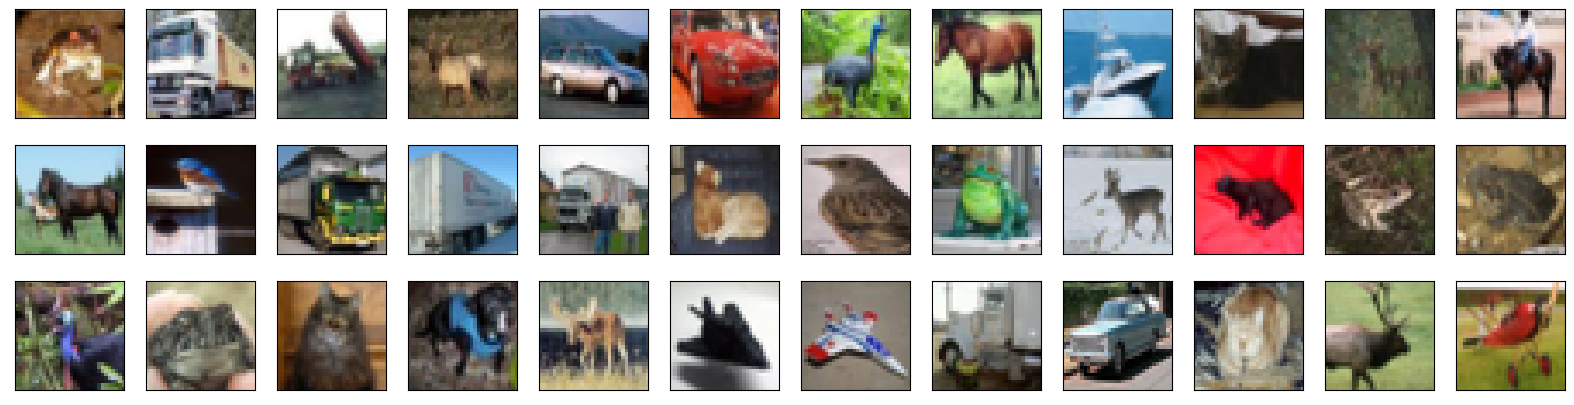

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

**3. Rescale the Images by Dividing Every Pixel in Every Image by 255**

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. Figure below shows Gradient Descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).

** Pointer: ** When using Gradient Descent, you should ensure that all features have a similar scale to speed up training or else it will take much longer to converge.

In [ ]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID
    
    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    # size = len(data)//num_clients
    size = [10000,7000,4000,13000,16000]
#     size = [500,500,500,500,500]
    # shards = [data[i:i + size] for i in range(0, size*num_clients, size)]
    shards = []
    num1 = 0
    for i in range(len(size)):
        num2 = size[i]
        shards.append(data[num1:num1 + num2])
        num1 = num1+num2
    print(type(shards))

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

In [ ]:
clients = create_clients(x_train, y_train, num_clients=5, initial='client')

<class 'list'>


In [ ]:
len(clients['client_1']), len(clients['client_2']),len(clients['client_3']), len(clients['client_4']), len(clients['client_5'])

(10000, 7000, 4000, 13000, 16000)

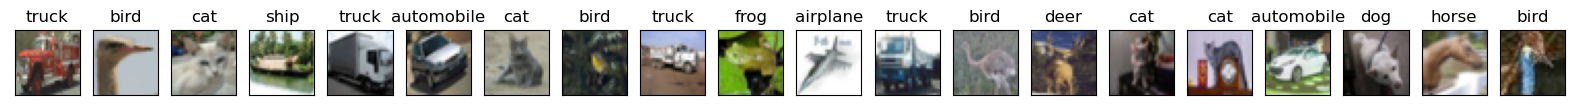

In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
    ax = fig.add_subplot(1, 20, i+1, xticks=[], yticks=[])
    ax.imshow(clients['client_1'][i][0], cmap='gray')
    ax.set_title(str(cifar10_labels[np.argmax(clients['client_1'][i][1])]))

In [ ]:
os.getcwd()

'C:\\Users\\Amit Kumar\\Desktop\\Sally Salem'

In [ ]:
current_directory = os.getcwd()

for client_name in clients.keys():
    final_directory = os.path.join(current_directory, client_name)
    if not os.path.exists(final_directory):
        os.makedirs(final_directory)
    os.chdir(final_directory)
    
    for j in range(len(clients[client_name])):
        img = clients[client_name][j][0]
        plt.imsave(client_name + "_" + str(j) + '.jpg',img)

In [ ]:
x_train1 = x_train[0:10000,]
y_train1 = y_train[0:10000,]

x_train2 = x_train[10000:17000,]
y_train2 = y_train[10000:17000,]

x_train3 = x_train[17000:21000,]
y_train3 = y_train[17000:21000,]

x_train4 = x_train[21000:34000,]
y_train4 = y_train[21000:34000,]

x_train5 = x_train[34000:50000,]
y_train5 = y_train[34000:50000,]

In [ ]:
class CNN:
    
    def build(self, classes):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
        model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(classes, activation='softmax'))
        
        return model

In [ ]:
X_train = [x_train1,x_train2,x_train3,x_train4,x_train5]
Y_train = [y_train1,y_train2,y_train3,y_train4,y_train5]

X_valid = [None,None,None,None,None]
Y_valid = [None,None,None,None,None]

accuracy = []
loss = []

In [ ]:
classes = 10
no_of_clients = 5
global_weights = []
model_class = CNN()

# train the global model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
global_model = model_class.build(classes)
global_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

global_model.fit(x_global, y_global, batch_size=32, epochs=50, verbose=1, shuffle=True)

global_weights = global_model.get_weights()

Epoch 1/50
157/157 [==============================] - 5s 24ms/step - loss: 5.6334 - accuracy: 0.1586
Epoch 2/50
157/157 [==============================] - 4s 23ms/step - loss: 2.0150 - accuracy: 0.2766
Epoch 3/50
157/157 [==============================] - 4s 23ms/step - loss: 1.8671 - accuracy: 0.3290
Epoch 4/50
157/157 [==============================] - 4s 23ms/step - loss: 1.7570 - accuracy: 0.3640
Epoch 5/50
157/157 [==============================] - 3s 21ms/step - loss: 1.6489 - accuracy: 0.4100
Epoch 6/50
157/157 [==============================] - 3s 21ms/step - loss: 1.5347 - accuracy: 0.4450
Epoch 7/50
157/157 [==============================] - 3s 21ms/step - loss: 1.4687 - accuracy: 0.4782
Epoch 8/50
157/157 [==============================] - 4s 24ms/step - loss: 1.3797 - accuracy: 0.4996
Epoch 9/50
157/157 [==============================] - 4s 26ms/step - loss: 1.2977 - accuracy: 0.5378
Epoch 10/50
157/157 [==============================] - 4s 25ms/step - loss: 1.2226 - accura

In [ ]:
no_of_rounds = 10
model = [None, None, None, None, None]
model_weights = [None, None, None, None, None]

for j in range(no_of_rounds):
    for i in range(no_of_clients):
        X_valid[i], X_train[i] = X_train[i][:round((X_train[i].shape[0]*(i+1))/20),], X_train[i][round((X_train[i].shape[0]*(i+1))/20):,]
        Y_valid[i], Y_train[i] = Y_train[i][:round((len(Y_train[i])*(i+1))/20)], Y_train[i][round((len(Y_train[i])*(i+1))/20):]
        model[i] = model_class.build(classes)
        model[i].compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
        model[i].set_weights(global_weights)
        model[i].fit(X_train[i], Y_train[i], batch_size=32, epochs=50,validation_data=(X_valid[i], Y_valid[i]),
                      callbacks=[early_stopping_cb], verbose=2, shuffle=True)
        model_weights[i] = model[i].get_weights()

    avg_weight = list()

    #getting the average weights accross all client weights
    for grad_list_tuple in zip(*model_weights):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)/no_of_clients
        avg_weight.append(layer_mean)

    global_weights = avg_weight
    
    global_model = model_class.build(classes)
    global_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

    global_model.set_weights(global_weights)

    loss.append(global_model.evaluate(x_test, y_test)[0])
    accuracy.append(global_model.evaluate(x_test, y_test)[1])

Epoch 1/50
297/297 - 7s - loss: 1.9635 - accuracy: 0.2595 - val_loss: 1.5302 - val_accuracy: 0.4600 - 7s/epoch - 24ms/step
Epoch 2/50
297/297 - 6s - loss: 1.5098 - accuracy: 0.4509 - val_loss: 1.2961 - val_accuracy: 0.5300 - 6s/epoch - 21ms/step
Epoch 3/50
297/297 - 6s - loss: 1.3532 - accuracy: 0.5052 - val_loss: 1.2126 - val_accuracy: 0.5420 - 6s/epoch - 21ms/step
Epoch 4/50
297/297 - 6s - loss: 1.2360 - accuracy: 0.5497 - val_loss: 1.2192 - val_accuracy: 0.5600 - 6s/epoch - 22ms/step
Epoch 5/50
297/297 - 6s - loss: 1.1668 - accuracy: 0.5821 - val_loss: 1.1660 - val_accuracy: 0.5700 - 6s/epoch - 21ms/step
Epoch 6/50
297/297 - 6s - loss: 1.0804 - accuracy: 0.6102 - val_loss: 1.1339 - val_accuracy: 0.5940 - 6s/epoch - 22ms/step
Epoch 7/50
297/297 - 6s - loss: 1.0133 - accuracy: 0.6339 - val_loss: 1.0474 - val_accuracy: 0.6200 - 6s/epoch - 22ms/step
Epoch 8/50
297/297 - 7s - loss: 0.9521 - accuracy: 0.6566 - val_loss: 1.0456 - val_accuracy: 0.6420 - 7s/epoch - 22ms/step
Epoch 9/50
297/2

Epoch 15/50
325/325 - 7s - loss: 0.5936 - accuracy: 0.7882 - val_loss: 1.0176 - val_accuracy: 0.6554 - 7s/epoch - 23ms/step
Epoch 16/50
325/325 - 7s - loss: 0.5679 - accuracy: 0.8023 - val_loss: 1.0352 - val_accuracy: 0.6473 - 7s/epoch - 23ms/step
Epoch 17/50
325/325 - 7s - loss: 0.5238 - accuracy: 0.8155 - val_loss: 1.0356 - val_accuracy: 0.6496 - 7s/epoch - 22ms/step
Epoch 18/50
325/325 - 7s - loss: 0.5134 - accuracy: 0.8188 - val_loss: 1.0312 - val_accuracy: 0.6585 - 7s/epoch - 22ms/step
Epoch 19/50
325/325 - 8s - loss: 0.4708 - accuracy: 0.8337 - val_loss: 1.0617 - val_accuracy: 0.6496 - 8s/epoch - 24ms/step
Epoch 1/50
375/375 - 10s - loss: 1.8927 - accuracy: 0.3038 - val_loss: 1.5006 - val_accuracy: 0.4392 - 10s/epoch - 27ms/step
Epoch 2/50
375/375 - 9s - loss: 1.4520 - accuracy: 0.4686 - val_loss: 1.3195 - val_accuracy: 0.5275 - 9s/epoch - 24ms/step
Epoch 3/50
375/375 - 9s - loss: 1.3020 - accuracy: 0.5361 - val_loss: 1.2648 - val_accuracy: 0.5550 - 9s/epoch - 23ms/step
Epoch 4/5

Epoch 1/50
282/282 - 8s - loss: 1.1451 - accuracy: 0.5929 - val_loss: 1.0144 - val_accuracy: 0.6570 - 8s/epoch - 27ms/step
Epoch 2/50
282/282 - 7s - loss: 1.0122 - accuracy: 0.6399 - val_loss: 0.9543 - val_accuracy: 0.6623 - 7s/epoch - 25ms/step
Epoch 3/50
282/282 - 7s - loss: 0.9206 - accuracy: 0.6733 - val_loss: 0.9754 - val_accuracy: 0.6530 - 7s/epoch - 25ms/step
Epoch 4/50
282/282 - 7s - loss: 0.8257 - accuracy: 0.7057 - val_loss: 0.9195 - val_accuracy: 0.6770 - 7s/epoch - 25ms/step
Epoch 5/50
282/282 - 6s - loss: 0.7675 - accuracy: 0.7327 - val_loss: 0.9097 - val_accuracy: 0.6843 - 6s/epoch - 23ms/step
Epoch 6/50
282/282 - 7s - loss: 0.6706 - accuracy: 0.7691 - val_loss: 0.9179 - val_accuracy: 0.6797 - 7s/epoch - 25ms/step
Epoch 7/50
282/282 - 7s - loss: 0.6355 - accuracy: 0.7788 - val_loss: 0.9315 - val_accuracy: 0.6840 - 7s/epoch - 24ms/step
Epoch 8/50
282/282 - 8s - loss: 0.5833 - accuracy: 0.7967 - val_loss: 0.8982 - val_accuracy: 0.6807 - 8s/epoch - 27ms/step
Epoch 9/50
282/2

Epoch 1/50
144/144 - 4s - loss: 0.9650 - accuracy: 0.6645 - val_loss: 0.7757 - val_accuracy: 0.7314 - 4s/epoch - 30ms/step
Epoch 2/50
144/144 - 3s - loss: 0.8554 - accuracy: 0.6924 - val_loss: 0.8424 - val_accuracy: 0.6941 - 3s/epoch - 22ms/step
Epoch 3/50
144/144 - 3s - loss: 0.7604 - accuracy: 0.7352 - val_loss: 0.7924 - val_accuracy: 0.7000 - 3s/epoch - 22ms/step
Epoch 4/50
144/144 - 3s - loss: 0.6558 - accuracy: 0.7677 - val_loss: 0.8076 - val_accuracy: 0.7118 - 3s/epoch - 20ms/step
Epoch 5/50
144/144 - 3s - loss: 0.5732 - accuracy: 0.7934 - val_loss: 0.8287 - val_accuracy: 0.7098 - 3s/epoch - 21ms/step
Epoch 6/50
144/144 - 3s - loss: 0.5229 - accuracy: 0.8199 - val_loss: 0.8159 - val_accuracy: 0.7255 - 3s/epoch - 21ms/step
Epoch 1/50
66/66 - 2s - loss: 0.9281 - accuracy: 0.6743 - val_loss: 0.7384 - val_accuracy: 0.7500 - 2s/epoch - 34ms/step
Epoch 2/50
66/66 - 1s - loss: 0.7495 - accuracy: 0.7371 - val_loss: 0.7182 - val_accuracy: 0.7582 - 1s/epoch - 21ms/step
Epoch 3/50
66/66 - 1

Epoch 8/50
134/134 - 3s - loss: 0.3665 - accuracy: 0.8728 - val_loss: 0.7229 - val_accuracy: 0.7559 - 3s/epoch - 25ms/step
Epoch 9/50
134/134 - 3s - loss: 0.3329 - accuracy: 0.8817 - val_loss: 0.7070 - val_accuracy: 0.7624 - 3s/epoch - 25ms/step
Epoch 1/50
119/119 - 4s - loss: 0.7657 - accuracy: 0.7310 - val_loss: 0.5395 - val_accuracy: 0.8175 - 4s/epoch - 37ms/step
Epoch 2/50
119/119 - 3s - loss: 0.6177 - accuracy: 0.7840 - val_loss: 0.5489 - val_accuracy: 0.8231 - 3s/epoch - 29ms/step
Epoch 3/50
119/119 - 3s - loss: 0.5736 - accuracy: 0.7924 - val_loss: 0.5131 - val_accuracy: 0.8278 - 3s/epoch - 29ms/step
Epoch 4/50
119/119 - 3s - loss: 0.4756 - accuracy: 0.8322 - val_loss: 0.5378 - val_accuracy: 0.8049 - 3s/epoch - 27ms/step
Epoch 5/50
119/119 - 3s - loss: 0.4132 - accuracy: 0.8596 - val_loss: 0.5438 - val_accuracy: 0.8167 - 3s/epoch - 25ms/step
Epoch 6/50
119/119 - 3s - loss: 0.3647 - accuracy: 0.8733 - val_loss: 0.5645 - val_accuracy: 0.8096 - 3s/epoch - 25ms/step
Epoch 7/50
119/1

Epoch 7/50
105/105 - 2s - loss: 0.3810 - accuracy: 0.8710 - val_loss: 0.7044 - val_accuracy: 0.7581 - 2s/epoch - 24ms/step
Epoch 8/50
105/105 - 2s - loss: 0.3365 - accuracy: 0.8794 - val_loss: 0.7603 - val_accuracy: 0.7366 - 2s/epoch - 24ms/step
Epoch 1/50
41/41 - 2s - loss: 0.7773 - accuracy: 0.7280 - val_loss: 0.7010 - val_accuracy: 0.7522 - 2s/epoch - 46ms/step
Epoch 2/50
41/41 - 1s - loss: 0.6136 - accuracy: 0.7864 - val_loss: 0.6474 - val_accuracy: 0.7699 - 923ms/epoch - 23ms/step
Epoch 3/50
41/41 - 1s - loss: 0.5129 - accuracy: 0.8262 - val_loss: 0.7068 - val_accuracy: 0.7345 - 957ms/epoch - 23ms/step
Epoch 4/50
41/41 - 1s - loss: 0.4463 - accuracy: 0.8418 - val_loss: 0.7237 - val_accuracy: 0.7699 - 939ms/epoch - 23ms/step
Epoch 5/50
41/41 - 1s - loss: 0.3716 - accuracy: 0.8644 - val_loss: 0.7794 - val_accuracy: 0.7566 - 925ms/epoch - 23ms/step
Epoch 6/50
41/41 - 1s - loss: 0.3114 - accuracy: 0.8917 - val_loss: 0.7751 - val_accuracy: 0.7478 - 946ms/epoch - 23ms/step
Epoch 7/50
41

Epoch 5/50
197/197 - 5s - loss: 0.3557 - accuracy: 0.8758 - val_loss: 0.4193 - val_accuracy: 0.8645 - 5s/epoch - 24ms/step
Epoch 6/50
197/197 - 4s - loss: 0.3186 - accuracy: 0.8894 - val_loss: 0.4419 - val_accuracy: 0.8675 - 4s/epoch - 23ms/step
Epoch 1/50
85/85 - 3s - loss: 0.8048 - accuracy: 0.7239 - val_loss: 0.5954 - val_accuracy: 0.7940 - 3s/epoch - 34ms/step
Epoch 2/50
85/85 - 2s - loss: 0.6567 - accuracy: 0.7685 - val_loss: 0.5697 - val_accuracy: 0.7841 - 2s/epoch - 24ms/step
Epoch 3/50
85/85 - 2s - loss: 0.5547 - accuracy: 0.8087 - val_loss: 0.5895 - val_accuracy: 0.8007 - 2s/epoch - 23ms/step
Epoch 4/50
85/85 - 2s - loss: 0.4597 - accuracy: 0.8378 - val_loss: 0.5902 - val_accuracy: 0.7841 - 2s/epoch - 23ms/step
Epoch 5/50
85/85 - 2s - loss: 0.4047 - accuracy: 0.8526 - val_loss: 0.5714 - val_accuracy: 0.7940 - 2s/epoch - 23ms/step
Epoch 6/50
85/85 - 2s - loss: 0.3360 - accuracy: 0.8887 - val_loss: 0.5954 - val_accuracy: 0.7907 - 2s/epoch - 28ms/step
Epoch 7/50
85/85 - 3s - loss

Epoch 2/50
29/29 - 1s - loss: 0.3733 - accuracy: 0.8690 - val_loss: 0.2362 - val_accuracy: 0.9333 - 732ms/epoch - 25ms/step
Epoch 3/50
29/29 - 1s - loss: 0.3137 - accuracy: 0.8946 - val_loss: 0.2381 - val_accuracy: 0.9067 - 746ms/epoch - 26ms/step
Epoch 4/50
29/29 - 1s - loss: 0.2254 - accuracy: 0.9290 - val_loss: 0.2350 - val_accuracy: 0.9233 - 712ms/epoch - 25ms/step
Epoch 5/50
29/29 - 1s - loss: 0.1900 - accuracy: 0.9467 - val_loss: 0.3074 - val_accuracy: 0.8867 - 713ms/epoch - 25ms/step
Epoch 6/50
29/29 - 1s - loss: 0.1543 - accuracy: 0.9501 - val_loss: 0.2647 - val_accuracy: 0.9000 - 756ms/epoch - 26ms/step
Epoch 7/50
29/29 - 1s - loss: 0.1394 - accuracy: 0.9634 - val_loss: 0.2803 - val_accuracy: 0.9033 - 699ms/epoch - 24ms/step
Epoch 8/50
29/29 - 1s - loss: 0.1083 - accuracy: 0.9723 - val_loss: 0.2602 - val_accuracy: 0.8967 - 761ms/epoch - 26ms/step
Epoch 9/50
29/29 - 1s - loss: 0.1136 - accuracy: 0.9678 - val_loss: 0.2806 - val_accuracy: 0.8867 - 852ms/epoch - 29ms/step
157/157 

In [ ]:
# global_model = model_class.build(classes)
# global_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# global_model.set_weights(global_weights)

# global_model.evaluate(x_test, y_test)

In [ ]:
accuracy_df = pd.DataFrame(columns = ['Round','Global_loss','Global_accuracy'])

In [ ]:
accuracy_df['Round'] = range(1,no_of_rounds+1)
accuracy_df['Global_loss'] = loss
accuracy_df['Global_accuracy'] = accuracy

In [ ]:
accuracy_df

,Round,Global_loss,Global_accuracy
0,1,1.338747,0.5036
1,2,0.924039,0.6806
2,3,0.876643,0.6906
3,4,0.848696,0.6978
4,5,0.837868,0.7072
5,6,0.827049,0.7112
6,7,0.827988,0.7118
7,8,0.825336,0.7122
8,9,0.843527,0.7128
9,10,0.842710,0.7150
